<a href="https://colab.research.google.com/github/Andarsan/well_selection/blob/main/github_%D0%92%D1%8B%D0%B1%D0%BE%D1%80_%D0%BB%D0%BE%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B4%D0%BB%D1%8F_%D1%81%D0%BA%D0%B2%D0%B0%D0%B6%D0%B8%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Вычисление доверительного интервала
from scipy import stats as st


import os
try:
  from google.colab import drive
  drive.mount('/content/drive')
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    message = template.format(type(ex).__name__, ex.args)
    print(message)


! pip install phik
# Вычисление матрицы корреляции с использованием phik
import phik
RANDOM_STATE = 42

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 14.4 MB/s eta 0:00:00


In [2]:
pth1 = '/datasets'#/ferma_main.csv'
pth2 = '/content/drive/MyDrive/Colab Notebooks/all_project'#/ferma_main.csv'
pth3 = 'C:/Users/andar/Downloads'
if os.path.exists(pth1):
  pth = pth1
elif os.path.exists(pth2):
  pth = pth2
elif os.path.exists(pth3):
  pth = pth3
else:
  pth = 'Something is wrong'
display(f'рабочий каталог: {pth}')

'рабочий каталог: /content/drive/MyDrive/Colab Notebooks/all_project'

In [3]:
def df_plt_describe(_df,_for):
  j=0
  for i in _for:
    # Set up the plot
    ax = plt.subplot(2, 2, j + 1)
    j = j+1
    # Draw the plot
    ax.boxplot(_df[i])
    # Title and labels
    ax.set_title(i)
  plt.tight_layout()
  plt.show()
  j=0
  #plt=reload(plt)
  for i in _for:
    # Set up the plot
    ax = plt.subplot(2, 2, j + 1)
    j = j+1
    # Draw the plot
    ax.hist(_df[i])
    # Title and labels
    ax.set_title(i)
  plt.tight_layout()
  plt.show()
  display(df_0[_for].describe())

* для отрисовки и анализа данных
* _df - датафрейм
* _for - список колонок

### `df_0` это `geo_data_0.csv`

In [4]:
df_0 = pd.read_csv(pth + '/geo_data_0.csv')
display(df_0.head(5))
display(df_0.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [5]:
display(len(df_0['id'].unique()))

99990

* скважины не уникальны посмотрим на дубликаты

In [6]:
_df_0 = df_0.groupby('id')['id'].count()
df_0[df_0['id'].isin(_df_0[_df_0.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


* данные разные значит все их удалим

In [7]:
df_0.drop_duplicates(subset='id',inplace=True)

In [8]:
_df_0 = df_0.groupby('id')['id'].count()
df_0[df_0['id'].isin(_df_0[_df_0.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product


* удалили
* пронумеровали заново

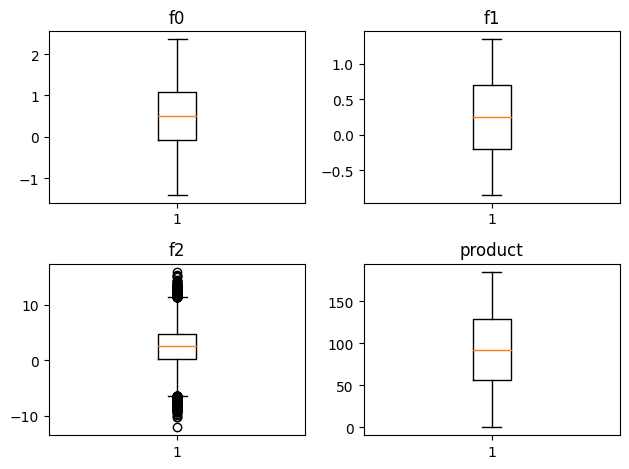

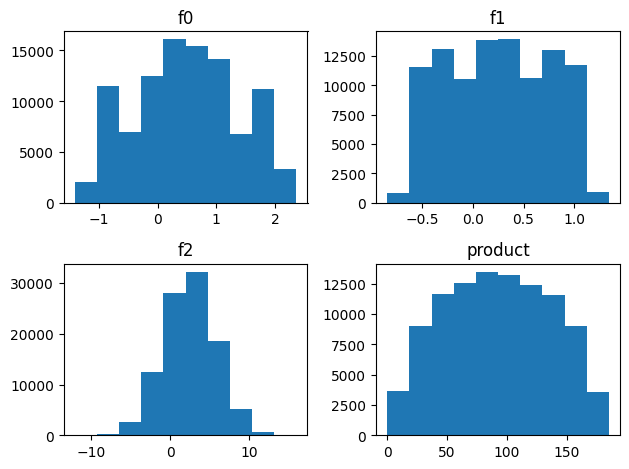

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [9]:
df_plt_describe(df_0,[ 'f0','f1','f2','product'])

* медиана и средняя почти одинаковы
*  выбросов больших нет

In [10]:
len(df_0['product'])

99990

### `df_1` это `geo_data_1.csv`

In [11]:
df_1 = pd.read_csv(pth + '/geo_data_1.csv')
display(df_1.head(5))

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
display(len(df_1['id'].unique()))

99996

In [13]:
_df_1 = df_1.groupby('id')['id'].count()
df_1[df_1['id'].isin(_df_1[_df_1.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [14]:
df_1.drop_duplicates(subset='id',inplace=True)

In [15]:
_df_1 = df_1.groupby('id')['id'].count()
df_1[df_1['id'].isin(_df_1[_df_1.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product


* тоже удалили

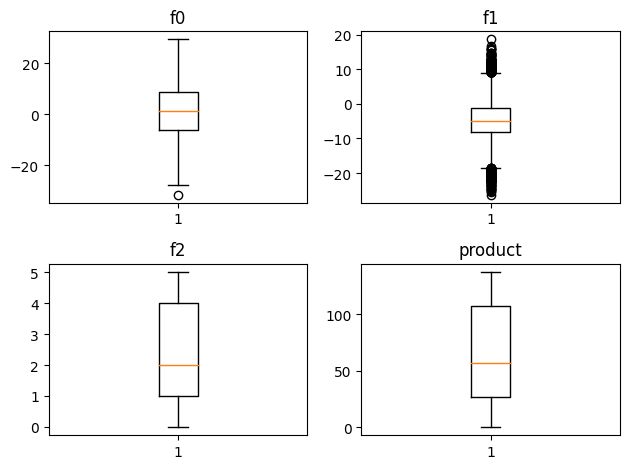

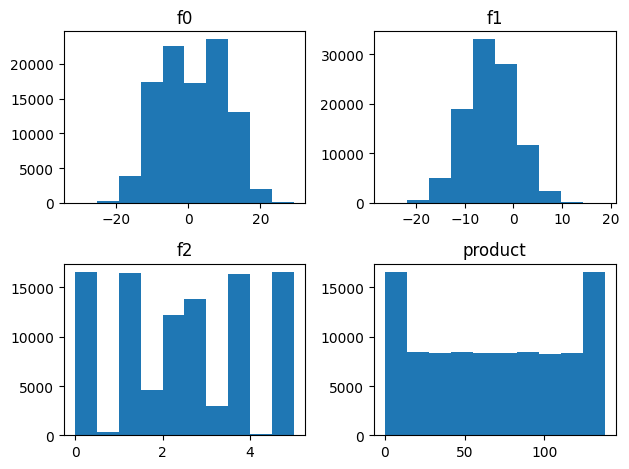

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [16]:
df_plt_describe(df_1,[ 'f0','f1','f2','product'])

### `df_2` это `geo_data_2.csv`

In [17]:
df_2 = pd.read_csv(pth + '/geo_data_2.csv')
display(df_2.head(5))
display(df_2.info())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [18]:
display(len(df_2['id'].unique()))

99996

In [19]:
_df_2 = df_2.groupby('id')['id'].count()
df_2[df_2['id'].isin(_df_2[_df_2.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


* тоже разные данные!
* будем удалять!

In [20]:
df_2.drop_duplicates(subset='id',inplace=True)

In [21]:
_df_2 = df_2.groupby('id')['id'].count()
df_2[df_2['id'].isin(_df_2[_df_2.values>1].index)].sort_values(by='id')

,id,f0,f1,f2,product


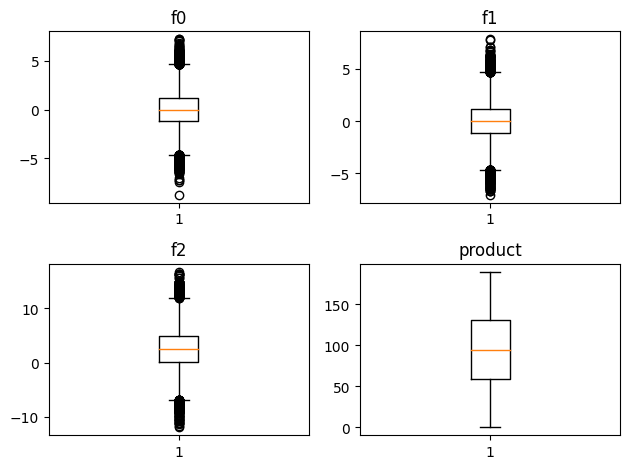

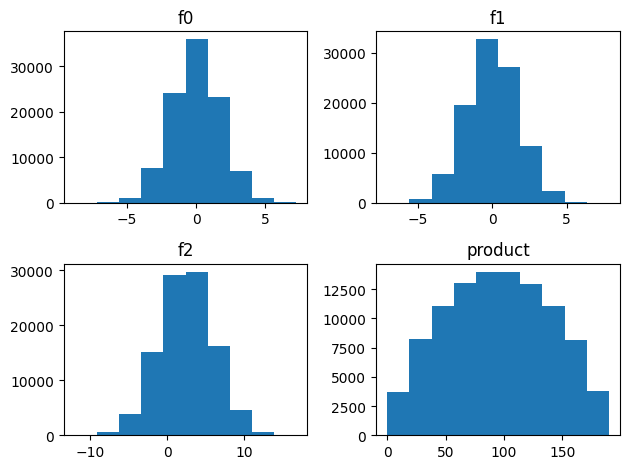

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [22]:
df_plt_describe(df_2,[ 'f0',	'f1',	'f2',	'product'])

* данные отличаются по каждаму региону
* но у всех регионов нет выбросов

* имеются одинаковые скважены в разных регионах
* их не много такчто удалим визде и все оденаковые

In [23]:
display('Регион 0 и 1 совпадения')
display(df_0[df_0['id'].isin(df_1['id'])])
display('Удаление по индексам')
drop_index_0 = df_0[df_0['id'].isin(df_1['id'])].index
drop_index_1 = df_1[df_1['id'].isin(df_0['id'])].index
display(drop_index_0.sort_values())
display(drop_index_1.sort_values())
df_0.drop(index=drop_index_0,inplace=True)
df_1.drop(index=drop_index_1,inplace=True)
display('Результат удаления')
display(df_0[df_0['id'].isin(df_1['id'])])

display('--------------------------------')
display('Регион 0 и 2 совпадения')
display(df_0[df_0['id'].isin(df_2['id'])])
drop_index_0 = df_0[df_0['id'].isin(df_2['id'])].index
drop_index_2 = df_2[df_2['id'].isin(df_0['id'])].index
display('Удаление по индексам')
display(drop_index_0.sort_values())
display(drop_index_2.sort_values())
df_0.drop(index=drop_index_0,inplace=True)
df_2.drop(index=drop_index_2,inplace=True)
display('Результат удаления')
display(df_0[df_0['id'].isin(df_2['id'])])

display('--------------------------------')
display('Регион 1 и 2 совпадения')
display(df_1[df_1['id'].isin(df_2['id'])])
display('Удаление по индексам')
drop_index_1 = df_1[df_1['id'].isin(df_2['id'])].index
drop_index_2 = df_2[df_2['id'].isin(df_1['id'])].index
display(drop_index_1.sort_values())
display(drop_index_2.sort_values())
df_1.drop(index=drop_index_1,inplace=True)
df_2.drop(index=drop_index_2,inplace=True)
display('Результат удаления')
display(df_1[df_1['id'].isin(df_2['id'])])
# сбросим индексы
df_0 = df_0.reset_index(drop=True)
df_1 = df_1.reset_index(drop=True)
df_2 = df_2.reset_index(drop=True)

'Регион 0 и 1 совпадения'

,id,f0,f1,f2,product
1419,Q64YW,0.453692,0.851595,1.483317,137.265232
14777,CXJ2r,1.799663,0.152615,2.308270,124.783815
44057,Y2udP,1.226808,-0.482702,7.197720,178.864963
44242,g3RRG,1.256835,-0.594468,2.258115,36.909351
66852,mpZhE,1.050752,0.001206,3.015799,102.323401
71547,L1Fdm,-0.870625,0.216046,6.551127,99.473405
75589,it2OW,-0.649660,0.966137,7.852383,152.939409
86152,gnA83,0.874183,0.658348,4.315275,78.952516
87474,Mp3uM,0.233182,0.999516,1.626957,109.425501
93783,pGQRI,0.042350,-0.052613,2.241901,168.331029


'Удаление по индексам'

Index([1419, 14777, 44057, 44242, 66852, 71547, 75589, 86152, 87474, 93783], dtype='int64')

Index([23086, 46293, 47203, 75179, 76544, 81779, 94352, 97856, 99665, 99975], dtype='int64')

'Результат удаления'

,id,f0,f1,f2,product


'--------------------------------'

'Регион 0 и 2 совпадения'

,id,f0,f1,f2,product
5191,wqgPo,2.009877,-0.119927,5.254332,72.798085
7781,kpKGs,1.984545,0.356201,-0.876743,53.006141
8454,scFN4,1.209207,-0.491543,0.871066,82.239907
10765,i2csb,1.876060,0.130102,3.916158,178.191619
11615,Suyut,1.034755,0.211378,5.166985,134.183249
14378,uSye4,1.452571,-0.452693,-1.800189,79.717634
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029
31017,tgOl6,1.242237,-0.545994,-1.070228,52.566338
45429,2tyMi,0.576679,-0.411140,-3.725859,69.292672
50393,TXPOv,-0.614415,0.669327,4.392560,111.029432


'Удаление по индексам'

Index([ 5191,  7781,  8454, 10765, 11615, 14378, 16753, 31017, 45429, 50393,
       58790, 62675, 65468, 69637, 84954, 88811, 90211],
      dtype='int64')

Index([ 7260,  9042, 13672, 17551, 27380, 27885, 31306, 48472, 49106, 50308,
       57741, 72896, 79311, 82577, 87965, 91259, 97706],
      dtype='int64')

'Результат удаления'

,id,f0,f1,f2,product


'--------------------------------'

'Регион 1 и 2 совпадения'

,id,f0,f1,f2,product
28877,TAqwC,-13.045712,-13.056006,0.007640,3.179103
38405,uMqiK,2.734183,-3.102346,-0.002654,0.000000
44738,D8TNs,-0.646266,3.667055,1.006161,30.132364
92366,g2I86,17.818406,2.946716,0.991640,26.953261


'Удаление по индексам'

Index([28877, 38405, 44738, 92366], dtype='int64')

Index([17007, 40478, 61622, 80750], dtype='int64')

'Результат удаления'

,id,f0,f1,f2,product


### Итог:

* в регионе `geo_data_0.csv` удалили 37 скважин
* в регионе `geo_data_1.csv` удалили 18 скважин
* в регионе `geo_data_2.csv` удалили 25 скважин

* данные отличаются по регионом похожи их не получиться объединить для обучения одной общей модели (нет понимания что это за данные).
* будем обучать модель для каждого региона, один регион одна модель.
* сбросили индексы


## Обучение и проверка модели

### Кориляция

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


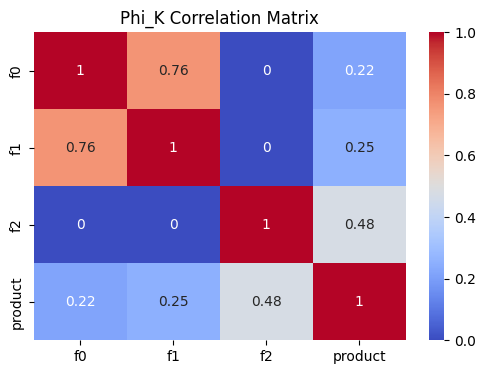

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


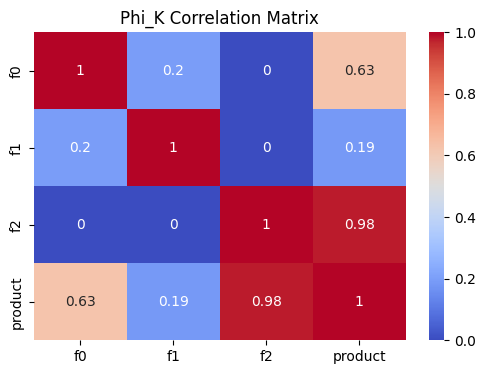

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


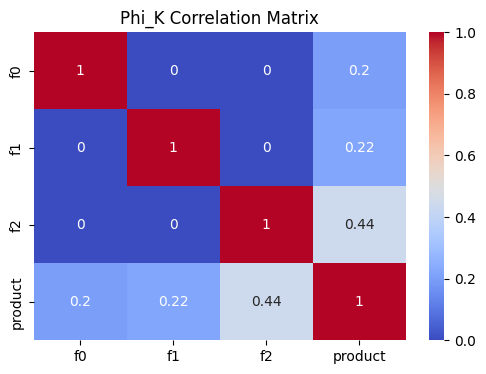

In [24]:
for i in ['df_0','df_1','df_2']:
  corr_matrix = globals()[i].drop('id', axis=1).phik_matrix()
  # Визуализация матрицы корреляции
  plt.figure(figsize=(6, 4))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
  plt.title('Phi_K Correlation Matrix')
  plt.show()

* в 1 регионе просматривается мультикориляция
* но мы с этим нечего поделать не можем

### Обучим и проверим модель для каждого региона

In [25]:
# все регионы все валедационные наборы и предсказания по ним будем записывать сюда
df_reg_valid_pred = {'df_0':[],'df_1':[],'df_2':[]}

for _df_reg in ['df_0','df_1','df_2']:

    features = globals()[_df_reg].drop(['id','product'], axis=1)
    target = globals()[_df_reg]['product']

    # разабьём на тренировочную и целевую 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = RANDOM_STATE)

    # приводим значения всех признаков к единой шкале
    scaler = StandardScaler()
    features_train = pd.DataFrame(scaler.fit_transform(features_train))
    features_valid = pd.DataFrame(scaler.transform(features_valid))

    model = LinearRegression()
    model = model.fit(features_train, target_train)
    pred = model.predict(features_valid)

    # правельные ответы и предсказанный результат запишим в словарик
    df_reg_valid_pred[_df_reg].append(pd.Series(target_valid).reset_index(drop=True))
    df_reg_valid_pred[_df_reg].append(pd.Series(pred))


    # результат
    display(f'Запас сырья в регионе : {_df_reg[3:]}')
    display(f'Средний предсказанный : {pred.mean()}')
    display(f'Средний фактический   : {target.mean()}')
    display(f'RМСЕ                  : {mean_squared_error(target_valid, pred, squared=False)}')
    display('------------------------')

'Запас сырья в регионе : 0'

'Средний предсказанный : 92.6457685220082'

'Средний фактический   : 92.49776240245946'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМСЕ                  : 37.67136600366545'

'------------------------'

'Запас сырья в регионе : 1'

'Средний предсказанный : 69.08251486551906'

'Средний фактический   : 68.82422825861059'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМСЕ                  : 0.8892843941268835'

'------------------------'

'Запас сырья в регионе : 2'

'Средний предсказанный : 94.74414231362438'

'Средний фактический   : 94.99708530681983'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМСЕ                  : 39.90954522540902'

'------------------------'

### Вывод

* 0 регион и 2 регион показывают высокий средний уровень нефти но ошибки очень велики можно наткнутца на скважену с ниским запасом нефти 92-37 = 55 и 94-40 = 54, но успакаивает то что средний предсказанный совпадает с фактическим
* 1 регион имеет низкий запас сырья но шибка наткнутся на ниский запас маленькая по сравнению с другими регионами 68-1 = 67

## Подготовка к расчёту прибыли

### Все ключевые значения сохраним в отдельные переменные

In [26]:
# сохраним данные
Total_well = 500 # всего исследуют
Super_well = 200 # лучших
Budget = 10000000000 # бюджет
Income = 450000 # доход с одной целевой единицы
State = np.random.RandomState(12345)


### Расчёт достаточного объёма сырья для безубыточной разработки новой скважины.

In [27]:
_min_oil = (Budget / Super_well / Income)
display(f'Для получения прибыли необходимо больше: {_min_oil:.2f} тыс.бар нефти с одной скважены')

'Для получения прибыли необходимо больше: 111.11 тыс.бар нефти с одной скважены'

### Сравним полученный объём сырья со средним запасом в каждом регионе.

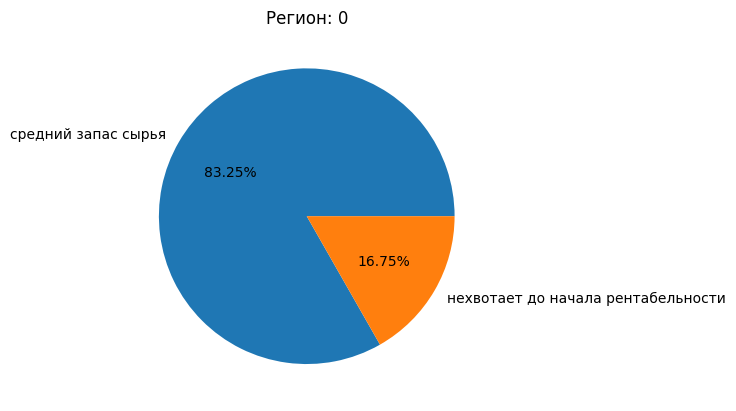

''

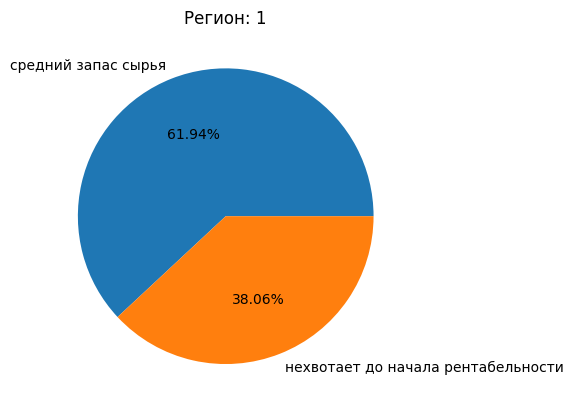

''

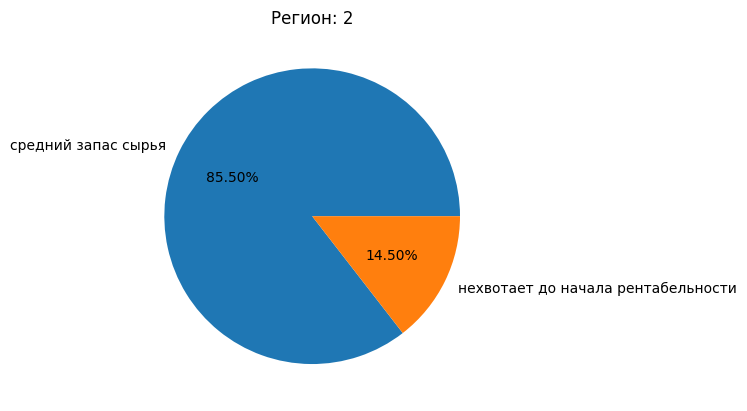

''

In [28]:
def pct(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%'.format(pct, v=val)
        return my_format

for _df_reg in ['df_0','df_1','df_2']:
   _s_0 = globals()[_df_reg]['product'].mean()
   _s_1 = _min_oil - _s_0
   s = [_s_0,_s_1]
   plt.pie(s,labels = ['средний запас сырья', 'нехвотает до начала рентабельности'], autopct=pct(s))
   plt.title('Регион: ' + _df_reg[3:])
   plt.show()
   display('')

* во всех регионах маловата сырья
* похоже второй регион самый перспективный для разработки
* но если бурить в слепую убыточность обеспечена
* но теперь у нас есть набор скважин с объёмом сырья как с предсказанным так и истинным в словаре `new_df_reg_valid_pred`
* будем выбирать из предсказанных

## Расчёт прибыли и рисков

###  Функцию для расчёта прибыли по лучим скважинам с максимальными значениями сырья.

In [29]:
# сортируем по прогнозу а считаем по факту
# истинное целевое (0)
# предсказанное целевое (1)
def def_many():
    for _reg in df_reg_valid_pred:
        # отберём 200 самых жирных из предсказанных:
        _index = df_reg_valid_pred[_reg][1].sort_values().tail(Super_well).index

        # суммируем истенные значения предсказанных скважен:
        mean = df_reg_valid_pred[_reg][0][_index].sum()

        mean = Income * mean - Budget
        display(f'регион  : {_reg[3:]}')
        display(f'выручка : {mean:,.0f} р.')
        display('----------------------------')
def_many()

'регион  : 0'

'выручка : 3,066,185,263 р.'

'----------------------------'

'регион  : 1'

'выручка : 2,415,086,697 р.'

'----------------------------'

'регион  : 2'

'выручка : 2,552,953,703 р.'

'----------------------------'

* похоже что 0 регион самый прибыльный

### Посчитаем риски и прибыль для каждого региона. Используем технику Bootstrap с 1000 выборками

In [30]:
# подсчёт прибыли из 200 самых жирных из 500 случайных:
# истинное целевое (0)
# предсказанное целевое (1)

def def_bootstrap(_reg, pred):
    money = []
    for i in range(1000):

        # отберём 200 самых жирных из предсказанных сэмплированных:
        _index = pred.sample(n=Total_well, replace=True, random_state=State).\
        sort_values().tail(Super_well).index


        # суммируем истенные значения предсказанных скважен:
        valid_sum = df_reg_valid_pred[_reg][0][_index].sum()

        money.append((Income * valid_sum) - Budget)

    return pd.Series(money)

# истинное целевое (0)
# предсказанное целевое (1)

def pred_many():
    for _reg in df_reg_valid_pred:
        itog = def_bootstrap(_reg,df_reg_valid_pred[_reg][1])
        mean = itog.mean()
        down = itog.quantile(0.025)
        up = itog.quantile(0.975)
        plt.show()
        risk = (itog < 0).mean() * 100
        display(f'регион                     : {_reg[3:]}')
        display(f'средняя выручка            : {mean:,.0f} р.')
        display(f'95% доверительный интервал : {down:,.0f} р. <---> {up:,.0f} р.')
        display(f'риск получить убытки       : {risk:.2f} %')
        display('----------------------------')
pred_many()

'регион                     : 0'

'средняя выручка            : 426,980,494 р.'

'95% доверительный интервал : -100,219,319 р. <---> 936,609,214 р.'

'риск получить убытки       : 5.60 %'

'----------------------------'

'регион                     : 1'

'средняя выручка            : 492,560,948 р.'

'95% доверительный интервал : 96,693,656 р. <---> 888,003,043 р.'

'риск получить убытки       : 0.90 %'

'----------------------------'

'регион                     : 2'

'средняя выручка            : 378,200,602 р.'

'95% доверительный интервал : -128,060,811 р. <---> 878,041,585 р.'

'риск получить убытки       : 8.10 %'

'----------------------------'

### Вывод:

* **Проведён подсчёт прибыли и рисков при освоении новых скважин в трёз регионах.**


- была представлена информация о 3х регионах с показателями и целевыми признаками, что позволило построить модель и предсказать объём сырья по трём регионам.
- в представленных данных были дублированные скважины с разными показателями, что говорит о возможных ошибках в сборе или обработке данных
- такие ошибки надо обязательно разбирать возможно это только верхушка айсберга
- в итоге было удалено 80 скважин с разных регионов
- простые расчёты показали что средний запас сырья ни в одном регионе не достаточен для получения прибыли.
- построенная модель показала что 1 регион очень предсказуем хотя имеет и меньше запасов сырья
- после применения модели и отбору самых объёмистых скважин в лидерах оказался 0 регион с прибылью до 3 млрд. казалось бы не плохо.


* **После использования техники Bootstrap с 1000 выборками можно сделать окончательный вывод:**


-  оказалось что имея достаточно точные предсказания в 1 регионе мы получим наибольшую прибыль при невысоких рисках.
- надо бурить в 1 регионе.
- и в дальнейшем не экономить на исследовании в области предсказания объёмов сырья это на прямую сказывается на прибыльность!

In [31]:
'end'

'end'